# Titanic — Avaliação Correta (OOF), Threshold Ótimo e Calibração


Implementa:
- OOF para avaliação justa
- Threshold ótimo (F1 e Youden J) em OOF
- Calibração opcional (sigmoid)
- Comparação Baseline Tabular vs Grafos (prior OOF)


In [51]:

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, networkx as nx
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, roc_curve, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

SEED=42; np.random.seed(SEED)
DATA_DIR=''; train_path=os.path.join(DATA_DIR,'train.csv'); test_path=os.path.join(DATA_DIR,'test.csv')


In [52]:

def best_threshold_f1(y_true, y_prob, n=181):
    ts = np.linspace(0.05, 0.95, n)
    scores = [f1_score(y_true, (y_prob>=t).astype(int)) for t in ts]
    ix = int(np.argmax(scores))
    return float(ts[ix]), float(scores[ix])

def youden_j_threshold(y_true, y_prob):
    fpr, tpr, thr = roc_curve(y_true, y_prob); j = tpr - fpr
    ix = int(np.argmax(j))
    return float(thr[ix]), float(j[ix])

def report_oof(name, y_true, y_prob, threshold=0.5, title_suffix=""):
    y_pred=(y_prob>=threshold).astype(int)
    print(f"=== {name} — OOF ==="); print("AUC:", round(roc_auc_score(y_true,y_prob),6))
    print("Brier:", round(brier_score_loss(y_true,y_prob),6))
    print(classification_report(y_true,y_pred))
    cm=confusion_matrix(y_true,y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} — Confusion Matrix (OOF){title_suffix}")
    plt.show()
    RocCurveDisplay.from_predictions(y_true,y_prob)
    plt.title(f"{name} — ROC (OOF){title_suffix}")
    plt.show()


In [53]:

train=pd.read_csv(train_path)
test=pd.read_csv(test_path)
TARGET='Survived'
FEATURES_NUM=['Age','SibSp','Parch','Fare']
FEATURES_CAT=['Pclass','Sex','Embarked']
FEATURES_ALL=FEATURES_NUM+FEATURES_CAT
X_tab=train[FEATURES_ALL].copy()
y=train[TARGET].values
numeric=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler(with_mean=False))])
categorical=Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output=True))])
pre_tab=ColumnTransformer([('num',numeric,FEATURES_NUM),('cat',categorical,FEATURES_CAT)])
models={
        'LR':LogisticRegression(max_iter=1000,random_state=SEED),
        'RF':RandomForestClassifier(random_state=SEED,n_estimators=500),
        'GB':GradientBoostingClassifier(random_state=SEED)
        }
pipes_tab={n:Pipeline([('prep',pre_tab),('clf',m)]) for n,m in models.items()}
cv5=StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)


AUC (CV-5) tabular: {'LR': 0.8514, 'RF': 0.8727, 'GB': 0.8706} | best: RF
Threshold F1(tab): 0.435 | F1@thr = 0.7630
Threshold Youden(tab): 0.438 | J = 0.6153
=== Tabular [RF] @thr=0.5 — OOF ===
AUC: 0.87094
Brier: 0.133881
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       549
           1       0.77      0.74      0.75       342

    accuracy                           0.81       891
   macro avg       0.81      0.80      0.80       891
weighted avg       0.81      0.81      0.81       891



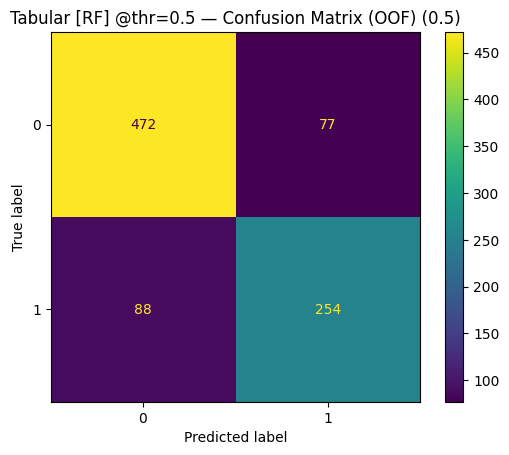

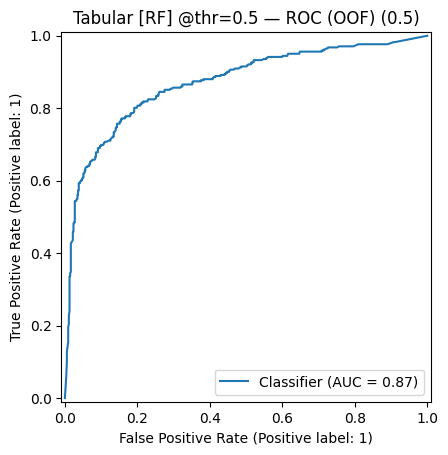

=== Tabular [RF] @thr=F1 — OOF ===
AUC: 0.87094
Brier: 0.133881
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       549
           1       0.75      0.77      0.76       342

    accuracy                           0.82       891
   macro avg       0.81      0.81      0.81       891
weighted avg       0.82      0.82      0.82       891



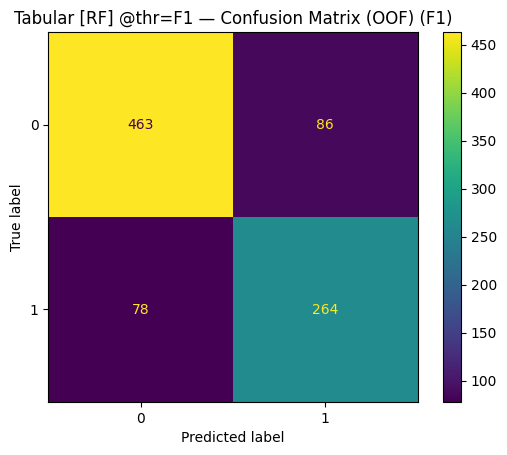

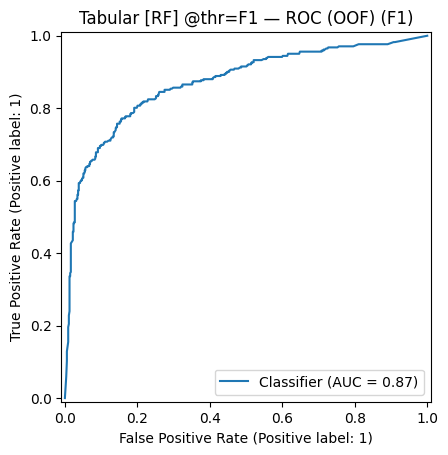

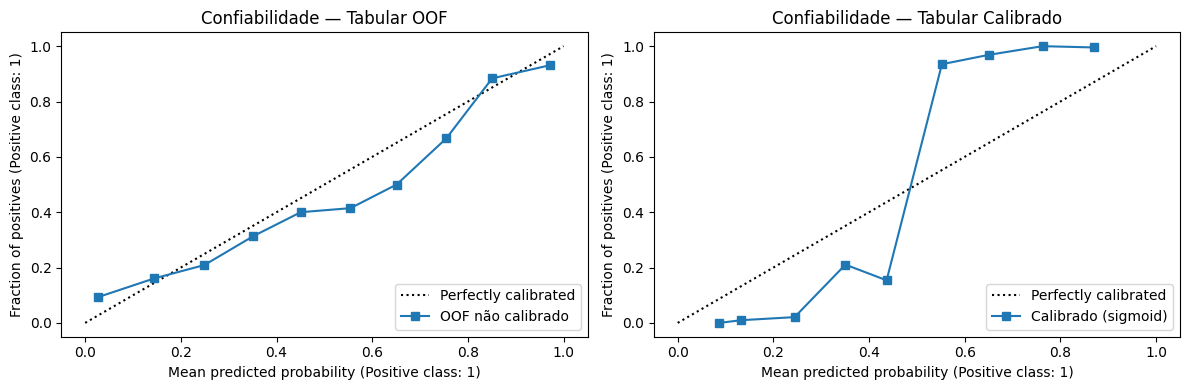

In [54]:

scores_tab={n:cross_val_score(p,X_tab,y,scoring='roc_auc',cv=cv5,n_jobs=-1).mean() for n,p in pipes_tab.items()}
best_name_tab=max(scores_tab,key=scores_tab.get)
best_pipe_tab=pipes_tab[best_name_tab]

print('AUC (CV-5) tabular:', {k:round(v,4) for k,v in scores_tab.items()}, '| best:', best_name_tab)
y_prob_oof_tab=cross_val_predict(best_pipe_tab,X_tab,y,cv=cv5,method='predict_proba')[:,1]
thr_f1_tab,f1_val_tab=best_threshold_f1(y,y_prob_oof_tab); thr_j_tab,j_val_tab=youden_j_threshold(y,y_prob_oof_tab)

print(f'Threshold F1(tab): {thr_f1_tab:.3f} | F1@thr = {f1_val_tab:.4f}'); print(f'Threshold Youden(tab): {thr_j_tab:.3f} | J = {j_val_tab:.4f}')
report_oof(f'Tabular [{best_name_tab}] @thr=0.5',y,y_prob_oof_tab,threshold=0.5,title_suffix=' (0.5)')
report_oof(f'Tabular [{best_name_tab}] @thr=F1',y,y_prob_oof_tab,threshold=thr_f1_tab,title_suffix=' (F1)')

best_pipe_tab.fit(X_tab,y)
X_tab_pre=best_pipe_tab.named_steps['prep'].transform(X_tab)
cal=CalibratedClassifierCV(best_pipe_tab.named_steps['clf'],method='sigmoid',cv=cv5)
cal.fit(X_tab_pre,y)
y_prob_cal=cal.predict_proba(X_tab_pre)[:,1]

fig,ax=plt.subplots(1,2,figsize=(12,4))

CalibrationDisplay.from_predictions(y_true=y,y_prob=y_prob_oof_tab,n_bins=10,name='OOF não calibrado',ax=ax[0])
ax[0].set_title('Confiabilidade — Tabular OOF')

CalibrationDisplay.from_predictions(y_true=y,y_prob=y_prob_cal,n_bins=10,name='Calibrado (sigmoid)',ax=ax[1])
ax[1].set_title('Confiabilidade — Tabular Calibrado')
plt.tight_layout(); plt.show()


In [55]:

# GRAFOS
train['_is_train']=1; test['_is_train']=0
def add_group_fields(df):
    out=df.copy()
    out['Surname']=out['Name'].str.extract(r'^(.*?),')
    ticket_root=out['Ticket'].astype(str).str.replace(r'\s+','',regex=True)
    out['FamilyID']=out['Surname'].fillna('')+'_'+ticket_root
    out['CabinDeck']=out['Cabin'].astype(str).str[0]; out.loc[out['Cabin'].isna(),'CabinDeck']='U'
    return out

train_g=add_group_fields(train)
test_g=add_group_fields(test)
full=pd.concat([train_g,test_g],ignore_index=True,sort=False)
G=nx.Graph()

for _,row in full.iterrows(): G.add_node(int(row['PassengerId']), is_train=int(row['_is_train']))

for _,idx in full.groupby('Ticket').indices.items():
    ids=full.loc[idx,'PassengerId'].astype(int).tolist()
    for i in range(len(ids)): 
        for j in range(i+1,len(ids)): G.add_edge(ids[i],ids[j],w=3.0,kind='ticket')

for _,idx in full.groupby('FamilyID').indices.items():
    ids=full.loc[idx,'PassengerId'].astype(int).tolist()
    for i in range(len(ids)): 
        for j in range(i+1,len(ids)): G.add_edge(ids[i],ids[j],w=2.0,kind='family')

for _,idx in full.groupby('CabinDeck').indices.items():
    ids=full.loc[idx,'PassengerId'].astype(int).tolist()
    for i in range(len(ids)-1): G.add_edge(ids[i],ids[i+1],w=0.5,kind='deck')

deg=dict(G.degree())
wdeg=dict(G.degree(weight='w'))
clust=nx.clustering(G,weight=None)
pr=nx.pagerank(G,alpha=0.85,weight='w')

comp_id,comp_size={},{} 
for cid,comp in enumerate(nx.connected_components(G)):
    size=len(comp)
    for node in comp: comp_id[node]=cid; comp_size[node]=size
    
graph_feats=pd.DataFrame({'PassengerId':list(G.nodes()),
                          'g_degree':[deg[n] for n in G.nodes()],
                          'g_wdegree':[wdeg[n] for n in G.nodes()],
                          'g_clustering':[clust.get(n,0.0) for n in G.nodes()],
                          'g_pagerank':[pr[n] for n in G.nodes()],
                          'g_component_size':[comp_size[n] for n in G.nodes()],
                          'g_component_id':[comp_id[n] for n in G.nodes()] })


In [56]:

full2=full.merge(graph_feats,on='PassengerId',how='left')
FEATURES_NUM_GRAPH = FEATURES_NUM + ['g_degree','g_wdegree','g_clustering','g_pagerank','g_component_size']

ID_COLS=['PassengerId','g_component_id','_is_train']
Xg_full=full2[FEATURES_NUM_GRAPH+FEATURES_CAT+ID_COLS].copy()

train_mask=full2['_is_train']==1
test_mask=full2['_is_train']==0

pids_train=full2.loc[train_mask,'PassengerId'].values
pids_test=full2.loc[test_mask,'PassengerId'].values
comp_train=full2.loc[train_mask,'g_component_id'].values
comp_test=full2.loc[test_mask,'g_component_id'].values
y_train=train.set_index('PassengerId')[TARGET].loc[pids_train].values

g_prior_comp_oof=np.zeros(len(pids_train),dtype=float)
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)

for tr_idx,val_idx in cv.split(np.zeros(len(pids_train)), y_train):
    p_tr,p_val=pids_train[tr_idx],pids_train[val_idx]
    c_tr,c_val=comp_train[tr_idx],comp_train[val_idx]
    y_tr=pd.Series(y_train[tr_idx],index=p_tr,name='y')
    comp_series_tr=pd.Series(c_tr,index=p_tr,name='comp')
    prior_tr=y_tr.groupby(comp_series_tr).mean()
    prior_val=pd.Series(c_val,index=p_val).map(prior_tr).astype(float).fillna(float(y_tr.mean()))
    g_prior_comp_oof[val_idx]=prior_val.values

y_tr_full=pd.Series(y_train,index=pids_train,name='y')
comp_series_full=pd.Series(comp_train,index=pids_train,name='comp')
prior_full=y_tr_full.groupby(comp_series_full).mean()

g_prior_comp_test=pd.Series(comp_test,index=pids_test).map(prior_full).astype(float).fillna(float(y_tr_full.mean()))
Xg_full.loc[train_mask,'g_prior_comp_oof']=g_prior_comp_oof
Xg_full.loc[test_mask,'g_prior_comp_oof']=g_prior_comp_test.values
X_g=Xg_full.loc[train_mask].drop(columns=ID_COLS).copy()
X_g_test=Xg_full.loc[test_mask].drop(columns=ID_COLS).copy()


AUC (CV-5) grafos: {'LR': 0.8551, 'RF': 0.8946, 'GB': 0.8864} | best: RF
Threshold F1(grafos): 0.375 | F1@thr = 0.7977
Threshold Youden(grafos): 0.376 | J = 0.6730
=== Grafos [RF] @thr=0.5 — OOF ===
AUC: 0.894063
Brier: 0.118308
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       549
           1       0.83      0.74      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



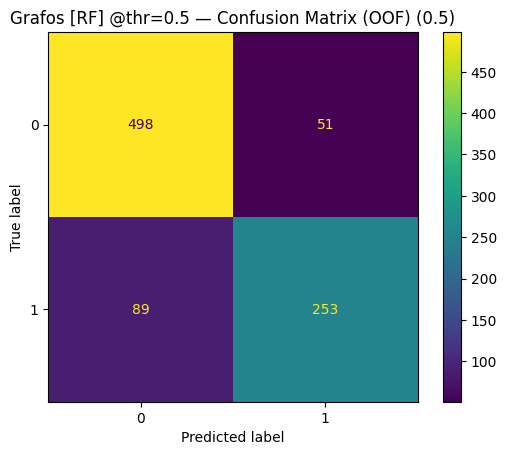

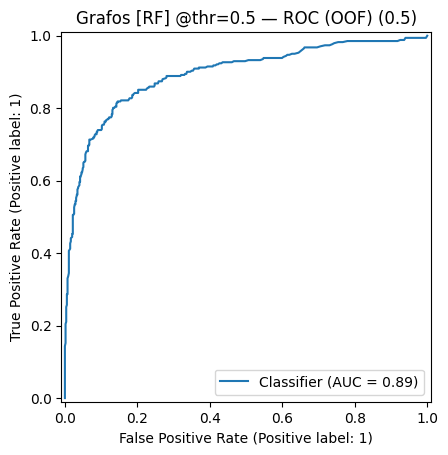

=== Grafos [RF] @thr=F1 — OOF ===
AUC: 0.894063
Brier: 0.118308
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       549
           1       0.78      0.82      0.80       342

    accuracy                           0.84       891
   macro avg       0.83      0.84      0.83       891
weighted avg       0.84      0.84      0.84       891



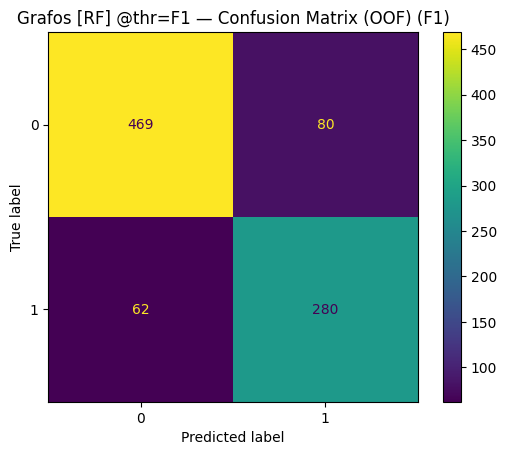

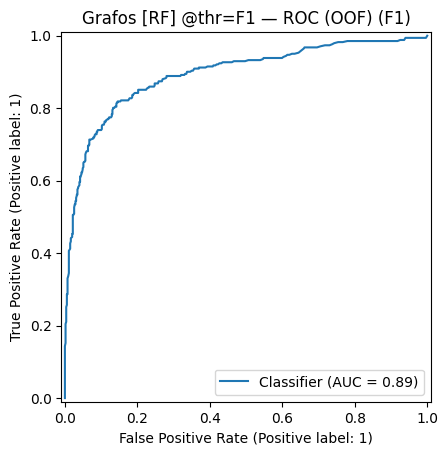

In [57]:

FEATURES_NUM_GRAPH_ALL = FEATURES_NUM_GRAPH+['g_prior_comp_oof']
pre_graph=ColumnTransformer([
    ('num',Pipeline([('imputer',SimpleImputer(strategy='median')),
                     ('scaler',StandardScaler(with_mean=False))]),FEATURES_NUM_GRAPH_ALL),
    ('cat',Pipeline([('imp',SimpleImputer(strategy='most_frequent')),
                     ('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output=True))]),FEATURES_CAT)])

pipes_graph={
        'LR':Pipeline([('prep',pre_graph),('clf',LogisticRegression(max_iter=1000,random_state=SEED))]),
        'RF':Pipeline([('prep',pre_graph),('clf',RandomForestClassifier(random_state=SEED,n_estimators=500))]),
        'GB':Pipeline([('prep',pre_graph),('clf',GradientBoostingClassifier(random_state=SEED))])}

scores_graph={n:cross_val_score(p,X_g,y_train,scoring='roc_auc',cv=cv5,n_jobs=-1).mean() for n,p in pipes_graph.items()}
best_name_graph=max(scores_graph,key=scores_graph.get)
best_pipe_graph=pipes_graph[best_name_graph]
print('AUC (CV-5) grafos:', {k:round(v,4) for k,v in scores_graph.items()}, '| best:', best_name_graph)

y_prob_oof_graph=cross_val_predict(best_pipe_graph,X_g,y_train,cv=cv5,method='predict_proba')[:,1]

thr_f1_g,f1_val_g=best_threshold_f1(y_train,y_prob_oof_graph)
thr_j_g,j_val_g=youden_j_threshold(y_train,y_prob_oof_graph)

print(f'Threshold F1(grafos): {thr_f1_g:.3f} | F1@thr = {f1_val_g:.4f}')
print(f'Threshold Youden(grafos): {thr_j_g:.3f} | J = {j_val_g:.4f}')

report_oof(f'Grafos [{best_name_graph}] @thr=0.5',y_train,y_prob_oof_graph,threshold=0.5,title_suffix=' (0.5)')
report_oof(f'Grafos [{best_name_graph}] @thr=F1',y_train,y_prob_oof_graph,threshold=thr_f1_g,title_suffix=' (F1)')


=== Consolidação (AUC OOF) ===
Tabular AUC (OOF): 0.87094
Grafos  AUC (OOF): 0.894063

=== Threshold ótimo (F1) ===
Tabular F1@thr*: 0.763
Grafos  F1@thr*: 0.7977


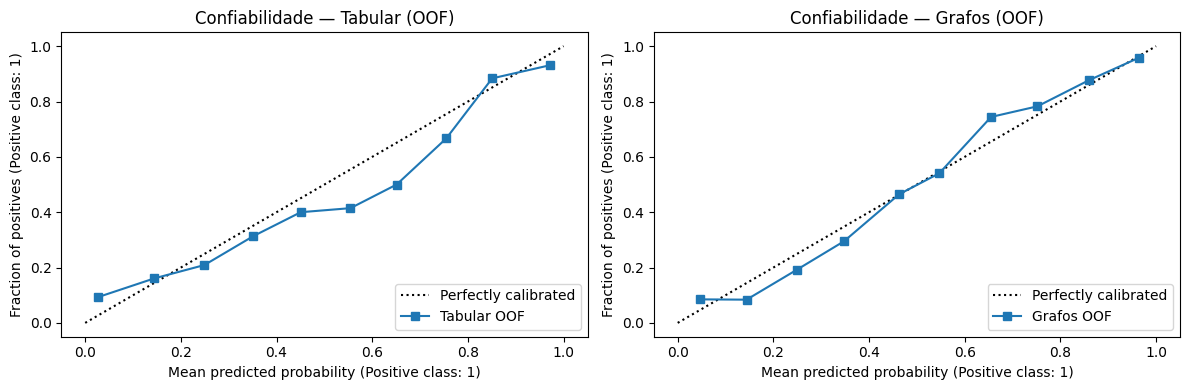

In [58]:

print('=== Consolidação (AUC OOF) ===')
print('Tabular AUC (OOF):', round(roc_auc_score(y, y_prob_oof_tab),6))
print('Grafos  AUC (OOF):', round(roc_auc_score(y_train, y_prob_oof_graph),6))
print('\n=== Threshold ótimo (F1) ===')
print('Tabular F1@thr*:', round(best_threshold_f1(y, y_prob_oof_tab)[1],4))
print('Grafos  F1@thr*:', round(best_threshold_f1(y_train, y_prob_oof_graph)[1],4))
fig,ax=plt.subplots(1,2,figsize=(12,4))
CalibrationDisplay.from_predictions(y_true=y, y_prob=y_prob_oof_tab, n_bins=10, name='Tabular OOF', ax=ax[0])
ax[0].set_title('Confiabilidade — Tabular (OOF)')

CalibrationDisplay.from_predictions(y_true=y_train, y_prob=y_prob_oof_graph, n_bins=10, name='Grafos OOF', ax=ax[1])
ax[1].set_title('Confiabilidade — Grafos (OOF)')

plt.tight_layout(); plt.show()